In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# load pickle data
with open('ensemble.pickle', 'rb') as f:
    ensemble = pickle.load(f)

2022-08-25 21:08:00.530333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 21:08:00.571353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/serg/.mujoco/mujoco210/bin:/home/serg/.mujoco/mujoco210/bin
2022-08-25 21:08:00.573351: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-25 21:08:00.573962: I tensorflow/core/platform/cpu_feature_guar

In [64]:
NUMBER_OF_MODEL = 2 # 0 - 11
predicted = ensemble.get_predicted()
indexes_split = ensemble.stores[NUMBER_OF_MODEL].indexes_split
price_data = ensemble.stores[NUMBER_OF_MODEL].dataset


In [65]:
train_data = price_data[price_data.index.isin(indexes_split[0])]
test_data = price_data[price_data.index.isin(indexes_split[1])]
print(len(train_data), len(test_data), len(predicted.get(f'LSTM_regressor_{NUMBER_OF_MODEL}')))

439 189 189


In [66]:
import plotly.graph_objects as go
predicted_0 = pd.DataFrame(predicted[f'LSTM_regressor_{NUMBER_OF_MODEL}'], columns=test_data.columns)
predicted_0['date'] = test_data.index

fig = go.Figure(data=[go.Candlestick(
                x=predicted_0['date'],
                open=predicted_0['open'],
                high=predicted_0['high'],
                low=predicted_0['low'],
                close=predicted_0['close'])])
fig_real = go.Figure(data=[go.Candlestick(
                x=test_data.index,
                open=test_data['open'],
                high=test_data['high'],
                low=test_data['low'],
                close=test_data['close'])])

fig.show()
fig_real.show()

In [63]:

TIME_POINT = 20
predicted_total = [predicted[f'LSTM_regressor_{i}'] for i in range(12)]
predicted_series = pd.DataFrame([i[TIME_POINT] for i in predicted_total], columns=test_data.columns)
fig = go.Figure(data=[go.Candlestick(
                x=predicted_series.index,
                open=predicted_series['open'],
                high=predicted_series['high'],
                low=predicted_series['low'],
                close=predicted_series['close'])])
fig.show()

actual_data = pd.DataFrame(test_data.values[TIME_POINT:TIME_POINT+12], columns=test_data.columns)
fig = go.Figure(data=[go.Candlestick(
                x=actual_data.index,
                open=actual_data['open'],
                high=actual_data['high'],
                low=actual_data['low'],
                close=actual_data['close'])])
fig.show()

In [48]:
# Backtest the models
trading_data = test_data.copy().reset_index()
cols = test_data.columns
trading_data['signal'] = 0 
for i, v in trading_data.iterrows():
    if i < 12:
        continue
    # take last 12 rows
    actual_data = trading_data.iloc[i-12:i][cols]
    for j in range(12):
        scaler = ensemble.stores[j].transformer.scaler
        model = ensemble.stores[j].model
        data = scaler.transform(actual_data.values)
        predicted = model.predict(data.reshape(-1, 12, len(cols)))
        expected_price = scaler.inverse_transform(predicted)
        open_price = actual_data['open'].values[0]
        min_price = min(min(i) for i in expected_price)
        min_prcie_percentage = (open_price - min_price) / open_price
        max_price = max(max(i) for i in expected_price)
        max_prcie_percentage = (open_price - max_price) / open_price
        range_price = max_price - min_price
        volatility = range_price / open_price
        last_price = actual_data.iloc[-1]['close']
    if max_prcie_percentage > 0:
        trading_data.loc[i, 'signal'] = 1
    if min_prcie_percentage < 0:
        trading_data.loc[i, 'signal'] = -1
    


1/1 [==============================] - 0s 14ms/step


In [49]:
# create target column
columns = []
for i in range(1, 13):
    name = f'target_{i}'
    columns.append(name)
    trading_data[name] = trading_data['close'].pct_change(i).shift(-i) * trading_data['signal']

In [50]:
trading_data.groupby('signal')[columns].agg(['mean', 'std', 'sum', 'count']).T

signal               0          1
target_1  mean     0.0  -0.002441
          std      0.0   0.008302
          sum      0.0  -0.063475
          count  162.0  26.000000
target_2  mean     0.0  -0.005075
          std      0.0   0.011227
          sum      0.0  -0.131955
          count  161.0  26.000000
target_3  mean     0.0  -0.008261
          std      0.0   0.013364
          sum      0.0  -0.214775
          count  160.0  26.000000
target_4  mean     0.0  -0.011540
          std      0.0   0.015299
          sum      0.0  -0.300029
          count  159.0  26.000000
target_5  mean     0.0  -0.015450
          std      0.0   0.016772
          sum      0.0  -0.401712
          count  158.0  26.000000
target_6  mean     0.0  -0.018159
          std      0.0   0.017449
          sum      0.0  -0.472146
          count  157.0  26.000000
target_7  mean     0.0  -0.020670
          std      0.0   0.017375
          sum      0.0  -0.537423
          count  156.0  26.000000
target_8  mean     0.0  -0.022810
          std      0.0   0.017448
          sum      0.0  -0.593062
          count  155.0  26.000000
target_9  mean     0.0  -0.024998
          std      0.0   0.017509
          sum      0.0  -0.649957
          count  154.0  26.000000
target_10 mean     0.0  -0.026633
          std      0.0   0.017172
          sum      0.0  -0.692471
          count  153.0  26.000000
target_11 mean     0.0  -0.029277
          std      0.0   0.017782
          sum      0.0  -0.761207
          count  152.0  26.000000
target_12 mean     0.0  -0.031290
          std      0.0   0.019281
          sum      0.0  -0.813552
          count  151.0  26.000000

<AxesSubplot:>

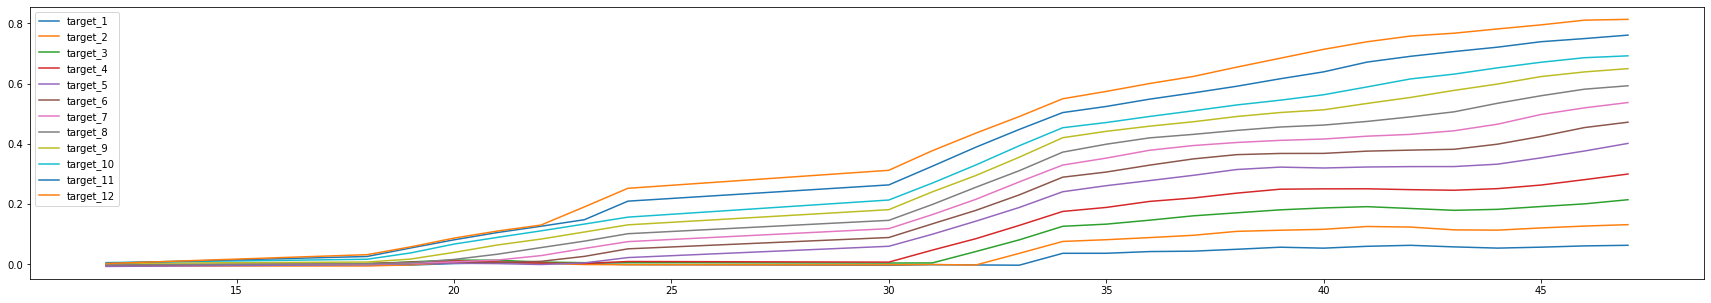

In [55]:
trading_data[trading_data['signal'] == 1][columns].cumsum().divide(-1).plot(figsize=(30, 5))